# Applying the MaxFilter after identifying bad sensors

## Introduction
The aim of this section is to demonstrate the application of the 'Maxwell filtering' and signal-space separation (SSS). The implementation termed MaxFilter serves to reduce artifacts from both environmental sources and sensor noise. The procedure also performs some fine-tuning and reduces the cross-talk between co-located sensors. Prior to applying the MaxFilter algorithm it is advisable to to remove sensors that are flat or have excessive artifacts ('bad'). If this is not done, it might result in the artifacts from faulty sensors being distributed to other sensors.

Specifically, the SSS is a technique derived from the physics of electromagnetism defined by the Maxwell equations (Taulu and Kajola 2005; Taulu and Simola 2006). The algorithm separates the measured signal into components attributable to sources respectively inside and outside the MEG sensor array. As the internal and external components are linearly independent, it is possible to suppress the contribution from the external components and thus reduce environmental noise sources. Maxwell filtering is a complementary procedure that omits the higher-order components dominated by sensor noise. In MNE-Python Maxwell filtering and SSS are performed by a single function.

## Preparation
First load the relevant Python modules:

In [1]:
import os.path as op
import os
import sys
import numpy as np

import mne
import matplotlib.pyplot as plt
import scipy

Define path to the local data and then define the file names:

In [3]:
# data_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\data'
data_path = r'C:\Users\Ole\Dropbox\FLUX\Development\FLUX\data'
#result_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\results'
result_path = r'D:\FLUX\results'
file_name = 'training_raw'
path_file = os.path.join(data_path,file_name +'-1.fif') 

crosstalk_file = os.path.join(data_path,'ct_sparse_SA.fif')
cal_file = os.path.join(data_path,'sss_cal_SA.dat')

Now read the raw data

In [4]:
data1 = mne.io.read_raw_fif(path_file, allow_maxshield=True,preload=True,verbose=True)

Opening raw data file C:\Users\Ole\Dropbox\FLUX\Development\FLUX\data\training_raw-1.fif...


<ipython-input-3-b03a13d9058b>:1: RuntimeWarning: This filename (C:\Users\Ole\Dropbox\FLUX\Development\FLUX\data\training_raw-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data1 = mne.io.read_raw_fif(path_file, allow_maxshield=True,preload=True,verbose=True)


    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.


Load the fine-calibration file. This file contains site-specific information relating to sensor orientation and calibration. If you cannot find them, please ask your local experts. The crosstalk compensation file have parameters used to reduce interference between co-located magnetometer and paired gradiometer sensor units.


### Idenfity the faulty sensors
The following scripts automatically identify the faulty sensors:

In [5]:
data1.info['bads'] = []
data1_check = data1.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = mne.preprocessing.find_bad_channels_maxwell(
    data1_check, 
    cross_talk=crosstalk_file, 
    calibration=cal_file,
    return_scores=True, 
    verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Scanning for bad channels in 291 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_SA.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Interval   1:    0.000 -    4.999
      

        Interval 173:  860.000 -  864.999
        Interval 174:  865.000 -  869.999
        Interval 175:  870.000 -  874.999
        Interval 176:  875.000 -  879.999
        Interval 177:  880.000 -  884.999
        Interval 178:  885.000 -  889.999
        Interval 179:  890.000 -  894.999
        Interval 180:  895.000 -  899.999
        Interval 181:  900.000 -  904.999
        Interval 182:  905.000 -  909.999
        Interval 183:  910.000 -  914.999
        Interval 184:  915.000 -  919.999
        Interval 185:  920.000 -  924.999
        Interval 186:  925.000 -  929.999
        Interval 187:  930.000 -  934.999
        Interval 188:  935.000 -  939.999
        Interval 189:  940.000 -  944.999
        Interval 190:  945.000 -  949.999
        Interval 191:  950.000 -  954.999
        Interval 192:  955.000 -  959.999
        Interval 193:  960.000 -  964.999
        Interval 194:  965.000 -  969.999
        Interval 195:  970.000 -  974.999
        Interval 196:  975.000 -  

Show which channels were detected as noisy and flat:

In [9]:
print('noisy =', auto_noisy_chs)
print('flat = ', auto_flat_chs)

noisy = ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']
flat =  []


**Question 1:** What is the name(s) of the faulty sensor(s)?


Set the noisy and flat sensors as 'bad' in the data set:

In [12]:
data1.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', data1.info['bads'])

bads = ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']


Change MEGIN magnetometer coil types (type 3022 and 3023 to 3023) to ensure compatibility across systems.

In [13]:
data1.fix_mag_coil_types()

99 of 99 magnetometer types replaced with T3.


<Raw | training_raw-1.fif, 343 x 1457000 (1457.0 s), ~3.73 GB, data loaded>

## Apply the Maxfilter and calibration

Apply the algorithm performing the Maxfiltering, SSS, calibration and cross-talk reduction:

In [14]:
data1_sss = mne.preprocessing.maxwell_filter(
    data1,
    cross_talk=crosstalk_file,
    calibration=cal_file,
    verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_SA.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Using 88/95 harmonic components for    0.000  (73/80 in, 15/15 out)
    Using loaded raw data
0 projection items deactivated
    Processing 145 data chunks
[done]


Plot the power spectra of raw data:

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


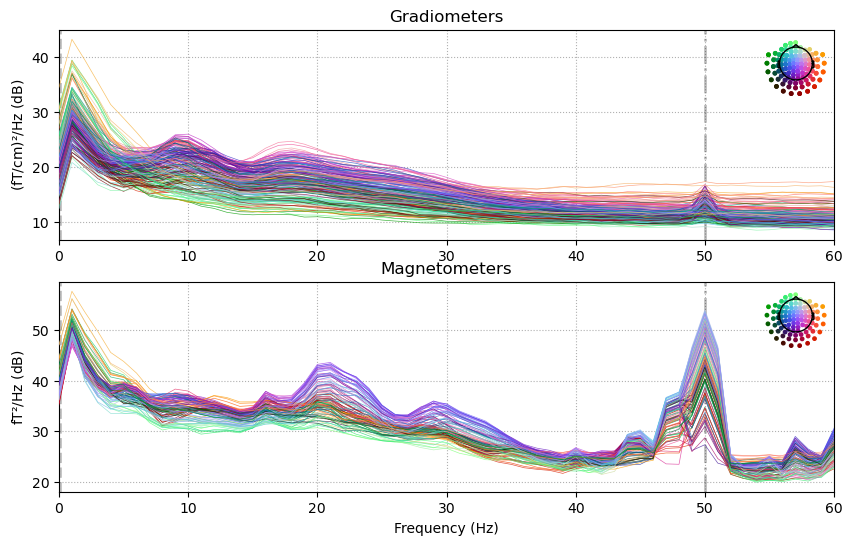

In [15]:
data1.plot_psd(fmax=60, n_fft = 1000);

and compared them to the power spectra after the application of the noise reduction algorithms:

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


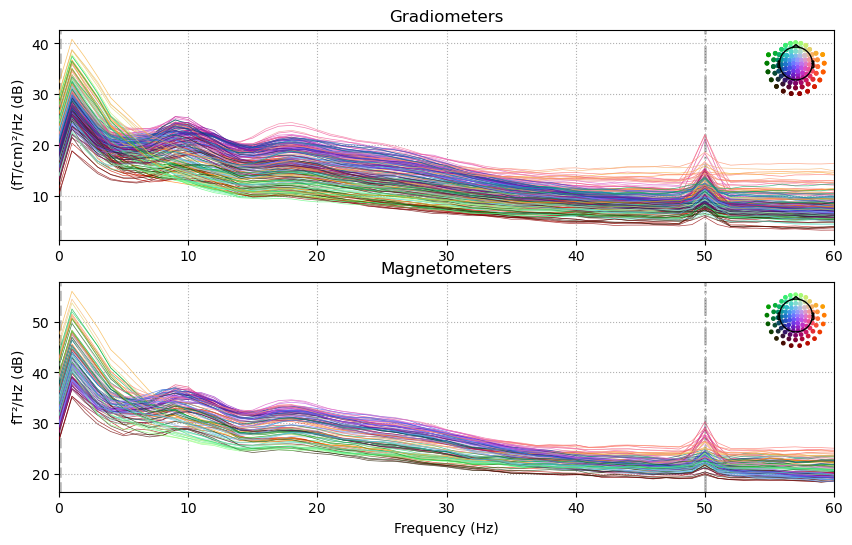

In [16]:
data1_sss.plot_psd(fmax=60, n_fft = 1000);

**Question 2:** What are the consequences of the SSS application for the 50 Hz peak of the magnetometers?

**Question 3:** Is the SSS most effective for the gradiometers or the magnetometers? Motivate the answer.

Save the result in a FIF-file. The result_path below is specific to your own setup:

In [18]:
path_file_results = os.path.join(result_path,file_name+'sss-1.fif') 
path_file_results
data1_sss.save(path_file_results,overwrite=True) 

Overwriting existing file.
Writing D:\FLUX\results\training_rawsss-1.fif


<ipython-input-18-8acffb81d34b>:3: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\results\training_rawsss-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data1_sss.save(path_file_results,overwrite=True)


Closing D:\FLUX\results\training_rawsss-1.fif
[done]


To complete the procedure perform the noise reduction procedure for the remaining sub-file. They will be stored in the result_path:

In [ ]:
path_file = os.path.join(data_path,file_name+'-2.fif') 
path_file_results = os.path.join(result_path,file_name+'sss-2.fif')     
    
dataTmp = mne.io.read_raw_fif(path_file, allow_maxshield=True,preload=True,verbose=True)
dataTmp.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
dataTmp.fix_mag_coil_types()
dataTmp_sss = mne.preprocessing.maxwell_filter(
   dataTmp,
   cross_talk=crosstalk_file,
   calibration=cal_file,
   verbose=True)
dataTmp_sss.save(path_file_results,overwrite=True) 
print(path_file_results)

Opening raw data file C:\Users\ferranto\Downloads\flux_sample\training_raw-2.fif...


<ipython-input-19-55d8199cb291>:4: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\training_raw-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  dataTmp = mne.io.read_raw_fif(path_file, allow_maxshield=True,preload=True,verbose=True)


    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
99 of 99 magnetometer types replaced with T3.
Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_SA.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.

<ipython-input-19-55d8199cb291>:12: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\results\training_rawsss-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  dataTmp_sss.save(path_file_results,overwrite=True)


## Preregistration and publication

Preregistration: report the sampling frequency and the properties of the anti-aliasing lowpass filter. Also report the peripheral data to be recorded (e.g. the EOG and ECG)

Publication, example:

"Sensors with excessive artifacts were marked from the data sets using a semi-automatic detection algorithm (about 8 per particant). Subsequently the Signal-Space Seperation (SSS) method (Taulu and Kajola, 2005) was applied to reduce environmental artifacts. SSS decomposes the data using multipole moments based on spherical harmonics and removes the component of magnetic field originating from outside the MEG helmet."

## References
Taulu,S. and Kajola, M. (2005) Presentation of electromagnetic multichannel data: the signal space separation method. Journal of Applied Physics, 97(12):124905 doi:10.1063/1.1935742.

Taulu, S. and Simola, J. (2006) Spatiotemporal signal space separation method for rejecting nearby interference in MEG measurements. Physics in Medicine and Biology, 51(7):1759–1768 doi:10.1088/0031-9155/51/7/008.